# Hands-On Stochastic Gradient Descent
***

In this notebook we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and evaluate those before proceeding. 


In [1]:
import numpy as np 
import matplotlib.pylab as plt 
%matplotlib inline

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

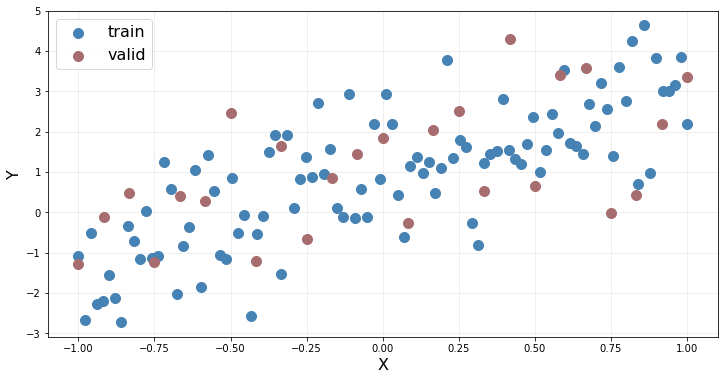

In [3]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n/4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n/4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16);

#Red is validation set, blue is training set and we will learn on training set.

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [4]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [6]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)
#bias 0.9, and the coefficient is 2.

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

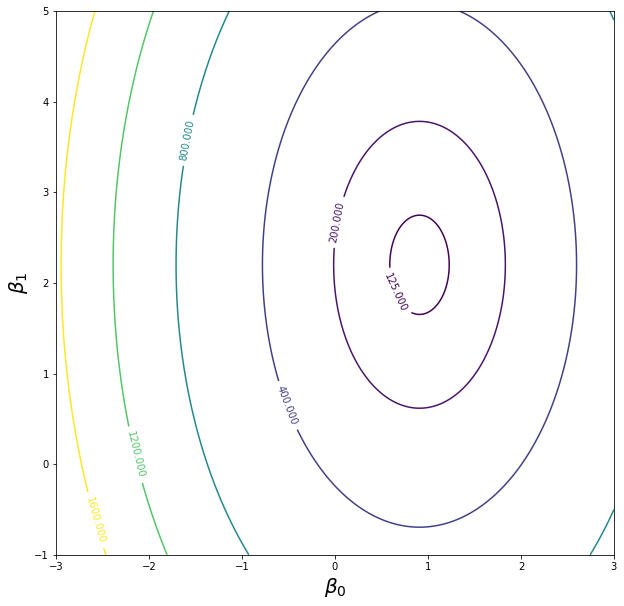

In [8]:
plotsurface(X_train, y_train)
#Plot surface of Beta 0 and Beta 1, shows you waht loss will look like for different values
#It becomes smaller and smaller as you reach center.

### Part 2: Implementing and Improving SGD 
***


**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes.  

In [15]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # loop over training examples 
        for index in shuffled_inds:
            #This gives you second part of the update equation
            prediction_error = beta[0] + beta[1] * X[index][1] - y[index]
            #Then we update Beta's. We can also use X[index][0] and it'd be no problem.
            beta[0] = beta[0] - eta * 2 * prediction_error # TODO
            beta[1] = beta[1] - eta * 2 * prediction_error * X[index][1] # TODO 

        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

Wall time: 248 ms
beta_0 = 0.90712, beta_1 = 2.20060


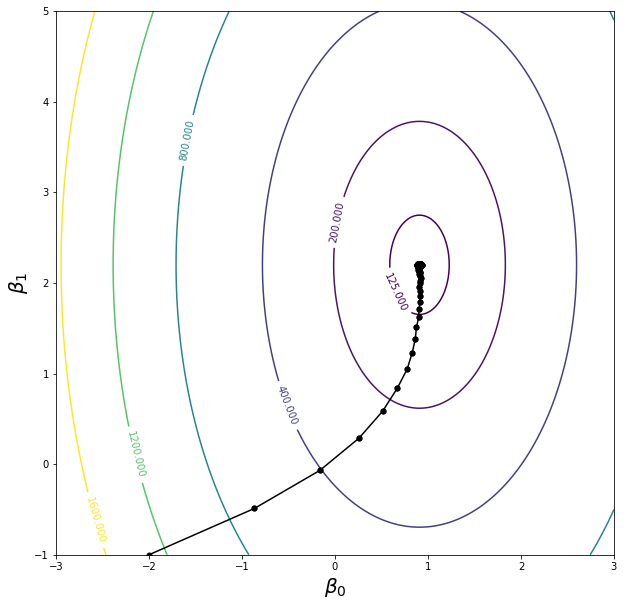

In [16]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 


In [20]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # loop over training examples 
        for index in shuffled_inds:
            # TODO
            #This gives you second part of the update equation
            #Key is to use dot product between two vetors.
            prediction_error = np.dot(beta, X[index]) - y[index]
            #Now we are trying to generalize beta updates instead of manually doing
            #beta[0] = ... or, beta[1] = ...
            beta = beta - eta * 2 * prediction_error * X[index]


        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

beta_0 = 0.91224, beta_1 = 2.20039


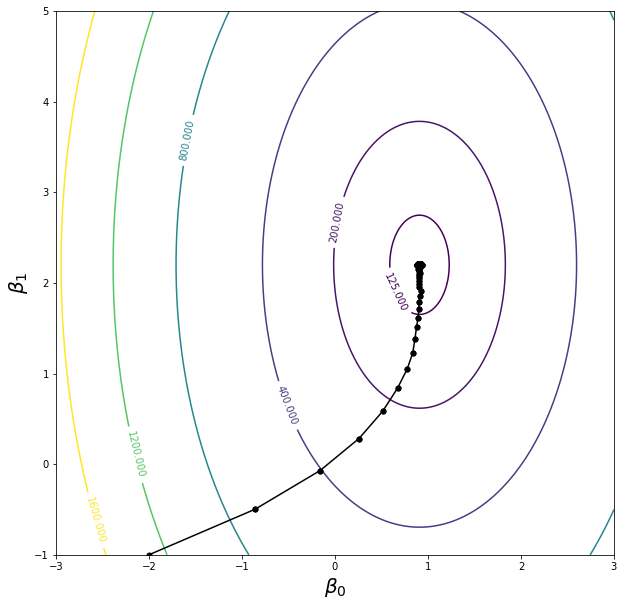

In [21]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part C**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 


beta_0 = 1.09712, beta_1 = 1.73354


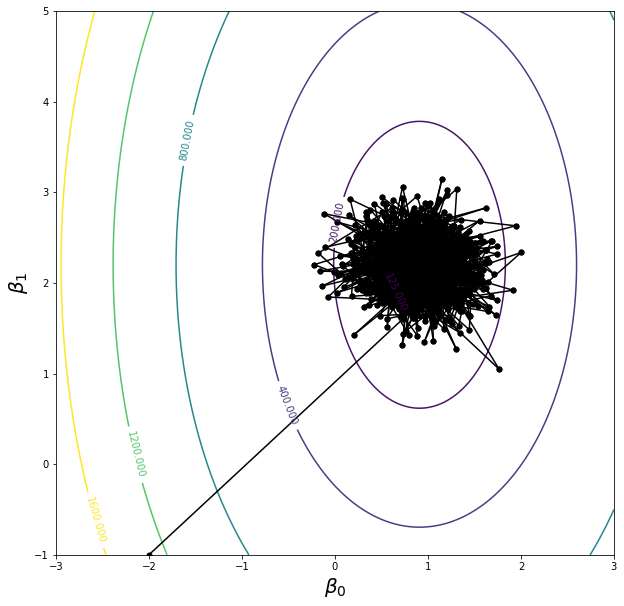

In [23]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.1, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

#This is unstable and non converging. At the end it didn't converge to a point.
#At the beginning it's fine, but we just immediately somewhere very close we need to ge eventually
#But then it jumps around and doesn't ever really converge.

beta_0 = 0.98961, beta_1 = 2.22020


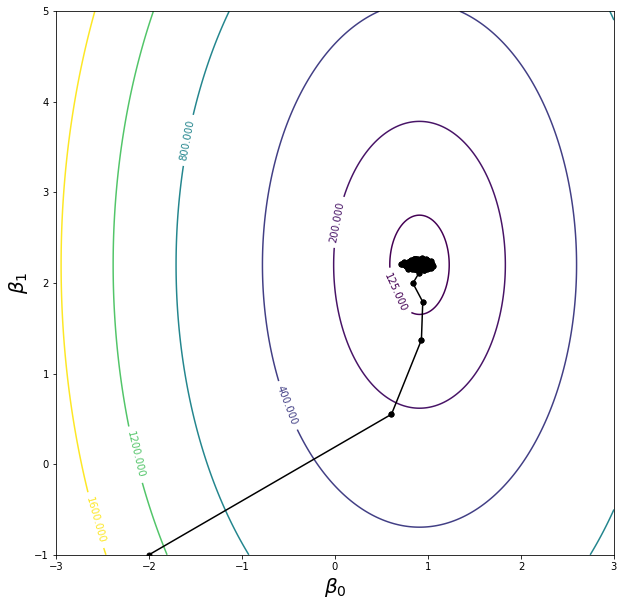

In [27]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.01, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

beta_0 = 0.90752, beta_1 = 2.20105


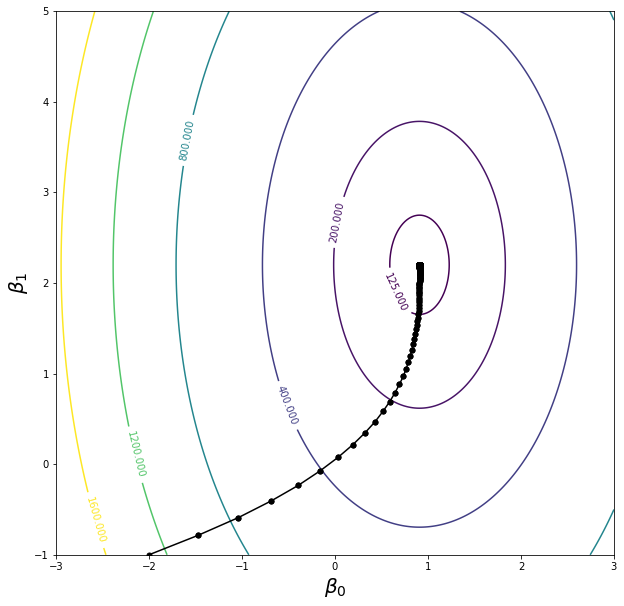

In [28]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.001, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

#This converges pretty nicely and is almost along 0.9 and 2.2, so that's good.

beta_0 = 0.90915, beta_1 = 2.19738


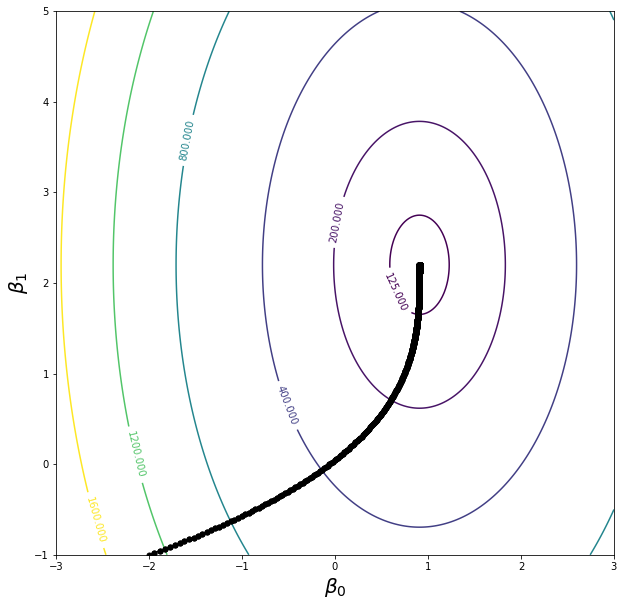

In [30]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0001, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

#This moves very slowly so we have dots at every step so the line looks thicker than the one above

beta_0 = 0.51548, beta_1 = 0.57952


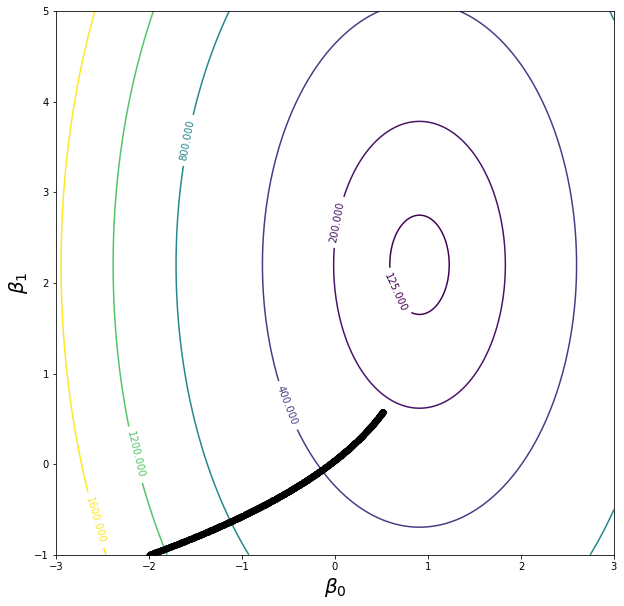

In [34]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.00001, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

#We will see our dots are very close together because learning rate is so small
#But we can not reach to final value.

### Part 3: Graphical Diagnosis of Convergence 
***

A common way to monitor the convergence of SGD and to tune hyperparameters (like learning rate and regularization strength) is to make a plot of how the loss function evolves during the training process. That is, we plot the value of the loss function periodically and see if it looks like it's reached a minimum, or see if it's jumping around a lot.  Normally we'd record the value of the loss function as we train, but we'll use the beta histories returned by our solver.  Finally, using the MSE instead of the RSS is a popular choice, so we'll do that.  

**Part A**: Modify the function below to take in a beta history and a data set and return a vector of MSE values for each epoch. 

In [35]:
def MSE_hist(X, y, bhist):
    #Mean Squared Error
    mse = np.zeros(bhist.shape[0])
    for epoch in range(bhist.shape[0]):
        #Beta history, we need to take the y corresponding to right epoch
        beta = bhist[epoch, :]
        prediction = np.dot(X, beta) #can also use matmul -> Matrix multiplication
        #prediction = np.matmul(X, beta)
        mse[epoch] = np.mean((y - prediction) ** 2) # TODO
    return mse

In [38]:
#We want to compute...
#beta[0] * X[i, 0] + beta[1] * X[i, 1] for every line
#Our input's shape is n * 2, and beta's shape is 2 * 1, so if we do
#matrix computation between x and beta...
#prediction size n * 1.
# X: n x 2
# Beta: 2 x 1
# Pred: n x 1

**Part B**: Next we'll take the MSE history that we just computed and plot it vs epoch number. Based on your plot, would you say that your MSE has converged? 

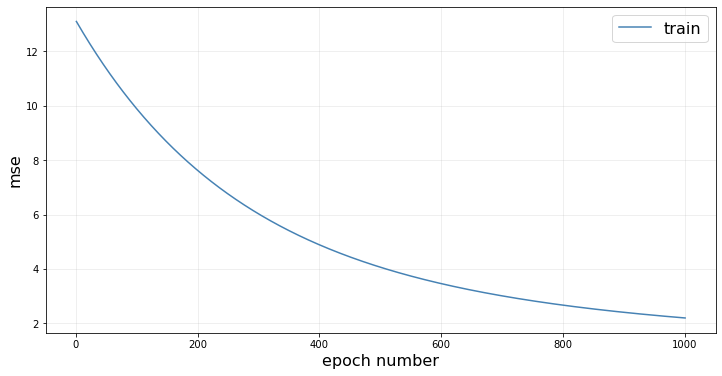

In [39]:
mse_train = MSE_hist(X_train, y_train, bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

**Part C**: Go back up and change the value of the learning rate to bigger and smaller values (you might also have to adjust the max epochs).  Do the different learning rates have the effect on the MSE plots that you would expect? 

<ipython-input-20-5108b70b7c1b>:31: RuntimeWarning: overflow encountered in double_scalars
  beta = beta - eta * 2 * prediction_error * X[index]
<ipython-input-35-d5703b44b0ff>:9: RuntimeWarning: overflow encountered in square
  mse[epoch] = np.mean((y - prediction) ** 2) # TODO


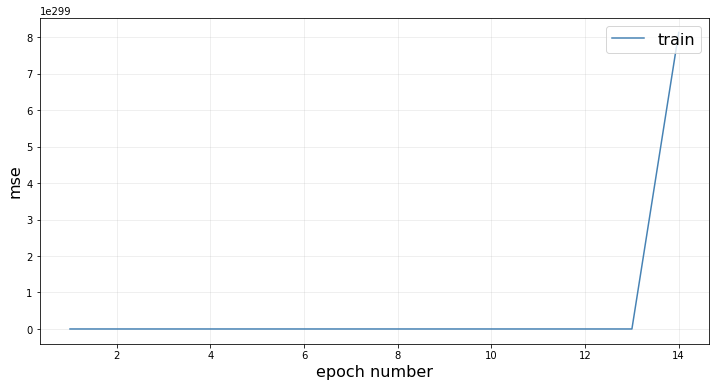

In [40]:
beta_start = np.array([-2.0, -1.0])
bhist = sgd(X_train, y_train, beta=beta_start, eta=1, num_epochs=1000)

mse_train = MSE_hist(X_train, y_train, bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

#Here it goes crazy!

beta_0 = 0.94910, beta_1 = 2.23572


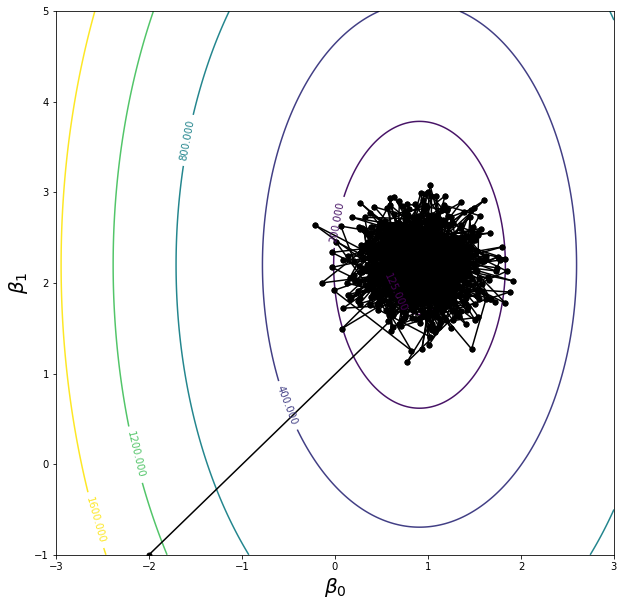

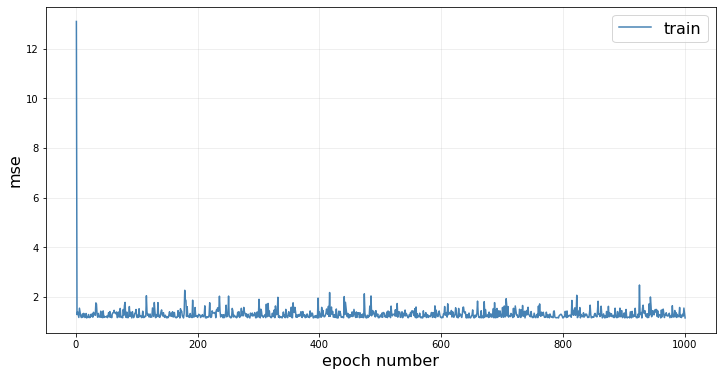

In [43]:
beta_start = np.array([-2.0, -1.0])
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.1, num_epochs=1000)

mse_train = MSE_hist(X_train, y_train, bhist)

print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

#Here you see how it diverges quickly and then just fluctuates.

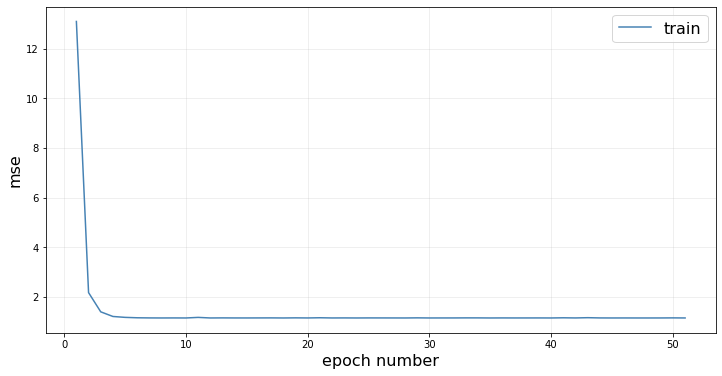

In [44]:
beta_start = np.array([-2.0, -1.0])
bhist = sgd(X_train, y_train, beta=beta_start, eta=0.01, num_epochs=50)

mse_train = MSE_hist(X_train, y_train, bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

#This converges at about 5 epochs! So we don't really need 1000 or 50.

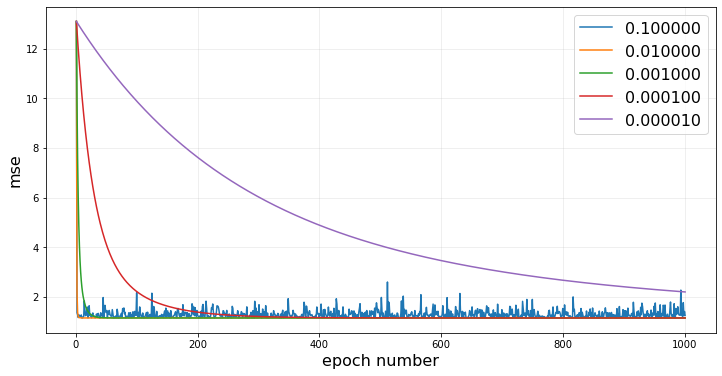

In [45]:
#beta_start = np.array([-2.0, -1.0])
#bhist = sgd(X_train, y_train, beta=beta_start, eta=0.01, num_epochs=50)

#mse_train = MSE_hist(X_train, y_train, bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
for eta in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=1000)
    mse_train = MSE_hist(X_train, y_train, bhist)
    ax.plot(range(1,len(mse_train)+1), mse_train, label='%f'%eta)
#ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);
#The convergence gets lower and lower as the learning rate gets small
#Orange green and red converge at about same level, lower than the purple

**Part D**: OK, now for the real question.  Is the MSE on the training data the best thing to look at when deciding if our training algorithm has converged? 

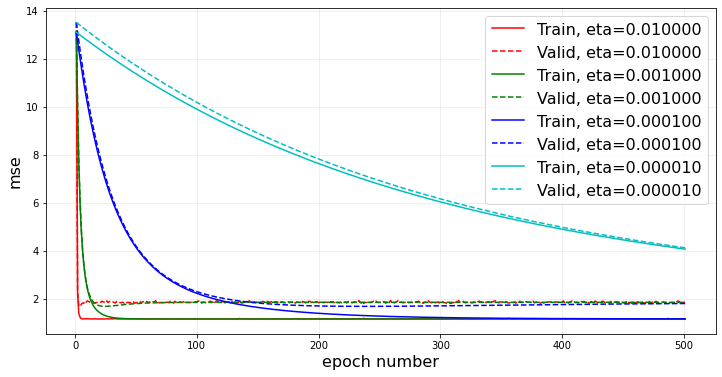

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
for eta, color in zip([0.01, 0.001, 0.0001, 0.00001], ['r', 'g', 'b', 'c']):
    bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=500)
    mse_valid = MSE_hist(X_valid, y_valid, bhist)
    mse_train = MSE_hist(X_train, y_train, bhist)
    ax.plot(range(1,len(mse_train)+1), mse_train, label='Train, eta=%f'%eta, color=color)
    ax.plot(range(1,len(mse_train)+1), mse_valid, label='Valid, eta=%f'%eta, linestyle='--', color=color)
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

#Need fewer Epochs with validation set.
#Validation always above training, you will make more mistake on validation set than on training

### Helper Functions
***

In [2]:
mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)